In [18]:
import os
import re


import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [19]:
# Define colors for modes
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import seaborn as sns

MODE_COLORS = {"hard": "blue", "soft": "red", "Weady et al.": "black"}
LINE_STYLES = {"$\\lambda = 10^{-2}$": "solid",
               "$\\lambda = 10^{-3}$": "dashed", "$\\lambda = 10^{-4}$": "dotted"}

In [20]:
from load_combined import load_combined

source_folders = [
    "../data/strong_scaling/",
 
]

# find recursive subfolders within source_folders
sim_dirs = []
for folder in source_folders:
    for root, dirs, files in os.walk(folder):
        # skip if /data as last part of path
        if "logs" in root or "data" in root.split(os.sep)[-1]:
            continue

        if any(f.endswith(".pvtu") for f in os.listdir(root)):
            sim_dirs.append(os.path.join(root))

particles_dict, sim_dict, params_dict = load_combined(sim_dirs, offset=0)

loading ../data/strong_scaling/1760916059116.569/output_hard/112ranks/vtk_output_hard
loading ../data/strong_scaling/1760916059116.569/output_soft/112ranks/vtk_output_soft
loading ../data/strong_scaling/1760916059116.569/output_soft/96ranks/vtk_output_soft
loading ../data/strong_scaling/1761142928038.939/output_hard/48ranks/vtk_output_hard
loading ../data/strong_scaling/1761180588593.814/output_soft/2ranks/vtk_output_soft
loading ../data/strong_scaling/1761180588593.814/output_soft/4ranks/vtk_output_soft
loading ../data/strong_scaling/1761142936463.112/output_soft/48ranks/vtk_output_soft
loading ../data/strong_scaling/1761142936463.112/output_soft/64ranks/vtk_output_soft


In [21]:
# print sizte of particles_dict in MB
print(f"Loaded particles_dict with {particles_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"Loaded sim_dict with {sim_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"Loaded params_dict with {params_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Loaded particles_dict with 368.72 MB
Loaded sim_dict with 0.07 MB
Loaded params_dict with 0.00 MB


In [22]:
sim_dict.keys()

Index(['iteration', 'simulation_time_s', 'time_since_last_log_s', 'step',
       'num_particles', 'num_constraints', 'colony_radius',
       'recursive_iterations', 'bbpgd_iterations', 'max_overlap', 'residual',
       'memory_usage_mb', 'peak_memory_mb', 'cpu_time_s', 'mpi_comm_time_s',
       'load_imbalance', 'dt_s', 'x', 'y', 'z', 'rank', 'Mode', 'Sensitivity',
       'sim_dir', 'offset'],
      dtype='object')

In [23]:
particles_dict["sim_dir"]

0         .._data_strong_scaling_1760916059116.569
1         .._data_strong_scaling_1760916059116.569
2         .._data_strong_scaling_1760916059116.569
3         .._data_strong_scaling_1760916059116.569
4         .._data_strong_scaling_1760916059116.569
                            ...                   
735064    .._data_strong_scaling_1761142936463.112
735065    .._data_strong_scaling_1761142936463.112
735066    .._data_strong_scaling_1761142936463.112
735067    .._data_strong_scaling_1761142936463.112
735068    .._data_strong_scaling_1761142936463.112
Name: sim_dir, Length: 735069, dtype: object

In [24]:
particles_dict["total_ranks"]=particles_dict["Sensitivity"].str.extract(r"(\d+)ranks")

In [38]:
from scipy.optimize import curve_fit

runtimes = []
for k, g in particles_dict.groupby(["Mode", "total_ranks", "sim_dir", "Sensitivity"]):
    src = g["Sensitivity"].unique()[0]

    sim_data = sim_dict[sim_dict["Sensitivity"] == src]

    final_time = sim_data["cpu_time_s"].max()

    colony_radius = sim_data["colony_radius"].max()

    runtimes.append(pd.DataFrame({
        "runtime [h]": [final_time / 3600],
        "Mode": [k[0]],
        "total_ranks": [int(k[1])],
        "sim_dir": [k[2]],
        "colony_radius": [colony_radius],
    }))
runtimes = pd.concat(runtimes, ignore_index=True)

runtimes

,runtime [h],Mode,total_ranks,sim_dir,colony_radius
0,0.836589,hard,112,.._data_strong_scaling_1760916059116.569,100.0000
1,0.769689,hard,48,.._data_strong_scaling_1761142928038.939,100.0040
2,7.735889,soft,112,.._data_strong_scaling_1760916059116.569,100.0000
3,5.934944,soft,2,.._data_strong_scaling_1761180588593.814,85.2585
4,5.283083,soft,4,.._data_strong_scaling_1761180588593.814,95.2585
5,2.334500,soft,48,.._data_strong_scaling_1761142936463.112,100.0000
6,3.692583,soft,64,.._data_strong_scaling_1761142936463.112,100.0000
7,6.606833,soft,96,.._data_strong_scaling_1760916059116.569,100.0000


In [26]:
def amdahl(N, p):
    return 1 / ((1 - p) + p / N)


def compute_speedup(group):

    if group[group["total_ranks"] == 1].empty:
        print("group has no baseline for speedup calculation")
        return group

    baseline = group[group["total_ranks"] == 1]
    baseline = baseline.iloc[0]["runtime [h]"]
    group = group.copy()
    group["speedup"] = baseline / group["runtime [h]"]

    N = group["total_ranks"].values
    S = group["speedup"].values

    # Fit p to all observed speedups
    popt, _ = curve_fit(amdahl, N, S, bounds=(0, 1))
    p_est = popt[0]

    group["amdahl"] = amdahl(N, p_est)
    group["p_est"] = p_est

    group["efficiency"] = group["speedup"] / group["total_ranks"]
    return group


runtimes = runtimes.groupby(["Mode", "sim_dir"]).apply(
    compute_speedup).reset_index(drop=True)

runtimes.sort_values(["Mode", "total_ranks"], inplace=True)
runtimes

runtimes

group has no baseline for speedup calculation
group has no baseline for speedup calculation
group has no baseline for speedup calculation
group has no baseline for speedup calculation
group has no baseline for speedup calculation


/tmp/ipykernel_621716/977333742.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  runtimes = runtimes.groupby(["Mode", "sim_dir"]).apply(


,runtime [h],Mode,total_ranks,sim_dir
1,0.769689,hard,48,.._data_strong_scaling_1761142928038.939
0,0.836589,hard,112,.._data_strong_scaling_1760916059116.569
6,5.934944,soft,2,.._data_strong_scaling_1761180588593.814
7,5.283083,soft,4,.._data_strong_scaling_1761180588593.814
4,2.334500,soft,48,.._data_strong_scaling_1761142936463.112
5,3.692583,soft,64,.._data_strong_scaling_1761142936463.112
3,6.606833,soft,96,.._data_strong_scaling_1760916059116.569
2,7.735889,soft,112,.._data_strong_scaling_1760916059116.569


In [27]:
for k, g in runtimes.groupby(["total_ranks", "Mode"]):
    print(k, len(g))

(np.int64(2), 'soft') 1
(np.int64(4), 'soft') 1
(np.int64(48), 'hard') 1
(np.int64(48), 'soft') 1
(np.int64(64), 'soft') 1
(np.int64(96), 'soft') 1
(np.int64(112), 'hard') 1
(np.int64(112), 'soft') 1


In [28]:
def makeplot(data, x, y, xlabel=None, ylabel=None, outname=None, variable="density",
             xscale=None, yscale=None,  hue="Mode",           **kwargs):

    fig, ax = plt.subplots(figsize=(10, 6))
    outname = outname or f"{y}_vs_{x}.png"

    sns.lineplot(data, x=x,                 y=y,
                 hue=hue, marker="o", ax=ax, **kwargs, lw=2, ms=10, palette=MODE_COLORS, style_order=LINE_STYLES.keys())

    if xscale:
        ax.set_xscale(xscale, base=2)
    if yscale:
        ax.set_yscale(yscale, base=2)

    ax.set_xlabel(xlabel or x, fontsize=20)
    ax.set_ylabel(ylabel or y, fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(True)
    ax.legend(fontsize=22)

    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")

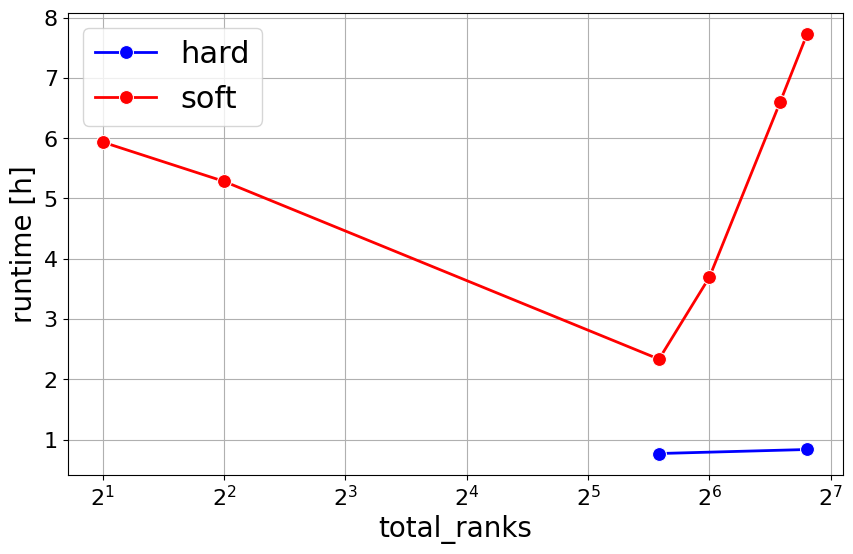

In [29]:
makeplot(runtimes, x="total_ranks", y="runtime [h]",
         outname="strong_scaling_runtime_hard_soft.png", xscale="log",  errorbar=("se",0.9))

In [30]:
avg = runtimes.groupby(['total_ranks', 'Mode']).mean(numeric_only=True).reset_index()

# pivot to have one column per model
pivot = avg.pivot(index='total_ranks', columns='Mode', values='runtime [h]')

# compute speedup factor (soft vs hard)
pivot['speedup_factor'] =  pivot['soft'] / pivot['hard'] 

print(pivot)

Mode             hard      soft  speedup_factor
total_ranks                                    
2                 NaN  5.934944             NaN
4                 NaN  5.283083             NaN
48           0.769689  2.334500        3.033044
64                NaN  3.692583             NaN
96                NaN  6.606833             NaN
112          0.836589  7.735889        9.246942


ValueError: Could not interpret value `speedup` for `y`. An entry with this name does not appear in `data`.

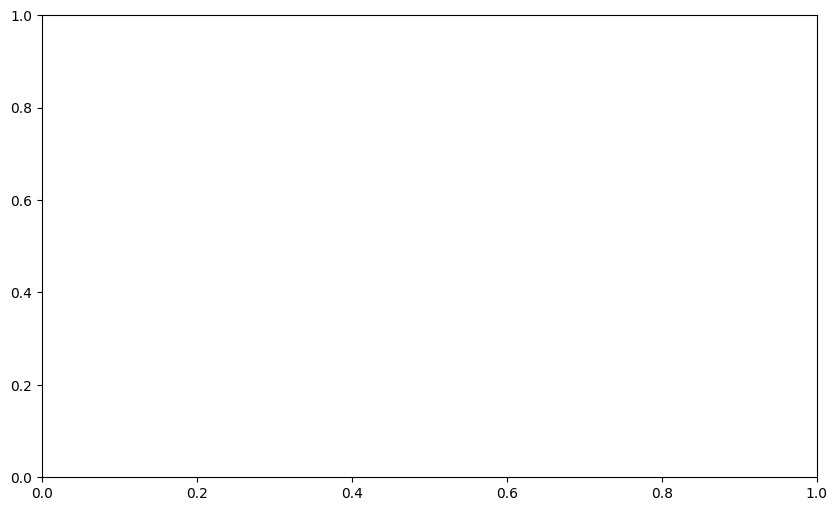

In [31]:
makeplot(runtimes, x="total_ranks", y="speedup",
         outname="strong_scaling_speedup_hard_soft.png", errorbar=("se", 0.3))

# plot y=x
x = np.linspace(1, 112, 100)

plt.gca().plot(x, x, color='gray', linestyle='--', label='ideal', linewidth=2)

# update legend
plt.gca().legend(fontsize=16)

# set y lim
plt.gca().set_ylim(0, 40)

# set y log

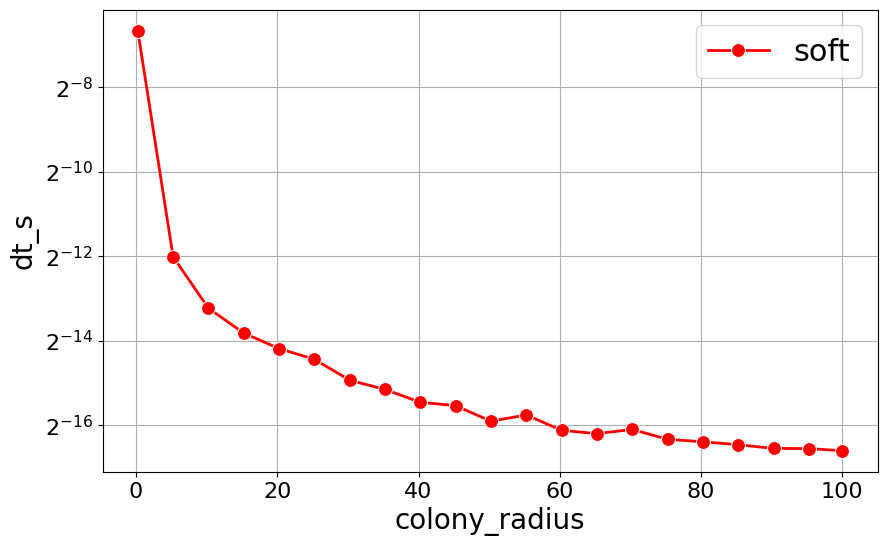

In [37]:
makeplot(sim_data, x="colony_radius", y="dt_s",
         outname="strong_scaling_runtime_hard_soft.png", yscale="log",  errorbar=("se",0.9))